### Notebook to be used to perform manual focus testing using ACCS Images

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter as gauss_filt
from matplotlib import pyplot as plt

import copy
from pathlib import Path

In [2]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [3]:
# Generate a set of test data
if False:
    array_size=(3520, 4656)
    psf_avg_pos = (array_size[0]/5.03, array_size[1]/3.05)
    psf_avg_sigma = float(18) # sigma in pixels
    max_pos_err= float(100.0) # maximum position random error in pixels
    max_sigma_err = float(3) # maximum variation in sigma
    amplitude = float(1000) #amplitude of gaussian
    dark_curr = 100
    n_frames = 11

    # Generate x,y,z data, where z is generated in the loop
    y, x = np.mgrid[:array_size[0], :array_size[1]]

    for n in np.arange(0,n_frames):
        # create base detector array
        im0 = np.zeros((array_size))+dark_curr
        # make Z array
        z=copy.deepcopy(im0)

        # put random offsets on parameters
        xoffset = max_pos_err*np.random.random()
        yoffset = max_pos_err*np.random.random()
        stddev_offset = max_sigma_err*np.random.random()

        # create data using astropy.modeling
        psf = models.Gaussian2D.evaluate(x,y, amplitude=amplitude, x_mean=psf_avg_pos[1]+xoffset,
                               y_mean=psf_avg_pos[0]+yoffset, 
                               x_stddev=psf_avg_sigma+stddev_offset,
                               y_stddev=psf_avg_sigma+stddev_offset,
                               theta=0.0)

        #add shot noise
        #psf+= (np.sqrt(psf)*np.random.randn(array_size[0], array_size[1]))

        # Display image?
        if False:
            fig2, ax2 = plt.subplots(figsize=(7,6))
            ax2.imshow(psf, interpolation='none')

        # Write the fits files
        hdu=None
        hdu = fits.PrimaryHDU(psf)
        hdul = fits.HDUList([hdu])
        fname = '20190910-generated-psf'+str(n)+'.fits'
        output_folder = Path("/home/saluser/data/20190910")
        print('writing psf file {}'.format(fname))
        hdul.writeto(output_folder / fname, overwrite=True)

In [4]:
np.random.random((1,2))

array([[0.36388517, 0.30426192]])

In [5]:
# Declare where data is located and where output will be written, notably the stacked images
data_folder = Path("/home/saluser/data/20190910")
output_folder = Path("/home/saluser/data/output")

# Raw image list from a manually made txt file
file_to_open = data_folder / "image_list.txt"
tmp=file_to_open.read_text()
image_fnames=tmp.split('\n')
#for i,f in enumerate(image_fnames):
#    image_fnames[i]+='.fits'
# remove last line as it has just .fits
image_fnames.remove(image_fnames[-1])

Displaying image 20190910-generated-psf6.fits


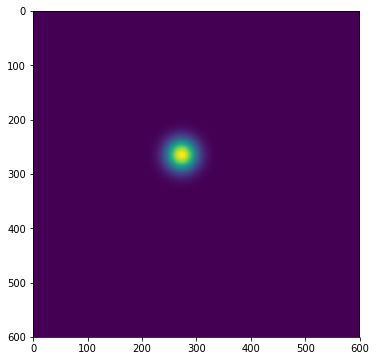

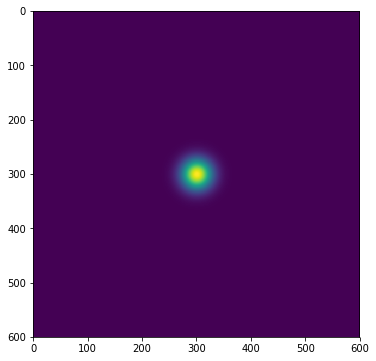

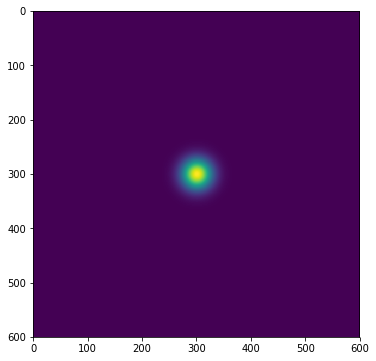

In [14]:
# declare size of image array
img_size=(3520, 4656) # y,x

# Declare center of first image (guess)
center_of_ref=(710, 1500)
logger.info('Center of image 0 is set as: {}'.format(center_of_ref))

# Declare sub-array size for centroiding
side=None
side=300
#Declare array for final doughnut
stacked_PSF = np.zeros((2*side, 2*side), dtype=float)

#Loop over all files in list
for i,fname in enumerate(image_fnames):
    
    with fits.open(data_folder / fname) as hdul0:
        logger.info("Processing file {}".format(fname))
        # data is [y,x]

        #raw_frame = circle
        raw_frame = copy.deepcopy(hdul0[0].data)
        #raw_frame[raw_frame<1e-2]=0
        
        # Create subimage
        d0=raw_frame[center_of_ref[0]-side:center_of_ref[0]+side, 
                        center_of_ref[1]-side:center_of_ref[1]+side].copy()
        
        #convert to float
        d1=copy.deepcopy(d0.astype(float))
        logger.debug('shape of d1: {}'.format(d1.shape))

        # subtract median background... which should do nothing to the centroid
        #d1= d0- np.median(d0)
        #d1 = copy.deepcopy(d0)
        #d_full=hdul0[0].data
        
        #boxcar smooth to remove hot pixels
        #d = ndimage.median_filter(d1, size=15)
        d = copy.deepcopy(d1)
        
        # Measure centroid (CofM) with corner reference 
        # FIX ME: DON"T KNOW WHY THIS DOESN'T WORK
        #corner=np.array(center_of_ref)-side
        #d_CofM = calc_CofM(d, corner) # y,x is 3179,923 (add y=20 gives 3160,923)
        #print('Corner coor d_CofM {}'.format(d_CofM))
        
        # Measure centroid (CofM)        
        #now without the reference
        d_CofM = np.array(calc_CofM(d)) # y,x i
        logger.debug('No corner correction d_CofM as calculated {}'.format(d_CofM))
    
        yoffset_to_center_of_ref = (d_CofM[0]-side)
        xoffset_to_center_of_ref = (d_CofM[1]-side)
        logger.debug('yoffset: {}'.format(yoffset_to_center_of_ref))
        logger.debug('xoffset: {}'.format(xoffset_to_center_of_ref))

        new_center = np.array((center_of_ref[0]+yoffset_to_center_of_ref,
                     center_of_ref[1]+xoffset_to_center_of_ref), dtype=int)
        
        logger.debug('new center is: {}'.format(new_center))
        
        # Create new stamp at CofM
        #del stamp
        stamp=raw_frame[new_center[0]-side:new_center[0]+side, 
                        new_center[1]-side:new_center[1]+side].copy()
        
        # Add it to the stack of doughnuts
        stacked_PSF+=stamp
  
        # Take the new center and use it as first guess at
        # position for next image
        center_of_ref = copy.deepcopy(new_center)
        
        # Display Imagefor troubleshooting (or finding first center)
        if i >= 7 and True: #7 is problematic
            mag=1
            print('Displaying image {}'.format(fname))
            #plt.rcParams['figure.figsize'] = [7*mag, 6*mag]
            #plt.imshow(d)
            
            fig, ax = plt.subplots(figsize=(7,6))

            ax.imshow(d, interpolation='none')#, extent=[center_of_ref[1]+side,
                                              #       center_of_ref[1]-side, 
                                              #       center_of_ref[0]+side,
                                              #       center_of_ref[0]-side])
            
            fig2, ax2 = plt.subplots(figsize=(7,6))
            ax2.imshow(stamp, interpolation='none')
            
            fig3, ax3 = plt.subplots(figsize=(7,6))
            ax3.imshow(stacked_PSF, interpolation='none')
            
            # show full frame
            #fig, ax = plt.subplots(figsize=(7,6))
            #ax.imshow(d_full, interpolation='none')
            
            break

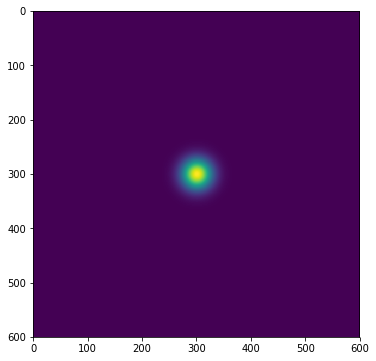

In [15]:
# Show final stacked doughnut
fig4, ax4 = plt.subplots(figsize=(7,6))
ax4.imshow(stacked_PSF, interpolation='none')

In [17]:
#Write fits files (if you want)
stacked_fname='PSF_20190908.fits'

if True:
    hdu=None
    hdu = fits.PrimaryHDU(stacked_PSF)
    hdul = fits.HDUList([hdu])
    print('writing stacked PSF file {}'.format(stacked_fname))
    hdul.writeto(output_folder / stacked_fname, overwrite=False)

writing stacked PSF file PSF_20190908.fits


In [18]:
# Open fits files, note you can start here if your files exist already
psf_fname = stacked_fname
#psf_fname='I1_intra_20190908.fits'

im=(fits.open(output_folder / psf_fname))[0].data

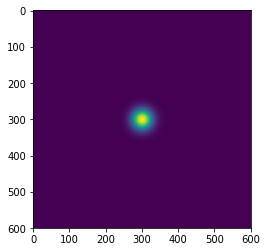

In [21]:
if True:
    im_sub=im-np.median(im)
    plt.imshow(im_sub)

In [25]:
# Find star by convolution with gaussian, then grab the max
tmp=gauss_filt(im,[5,5],mode='constant',cval=0)
print(np.max(tmp))
value=None
ind=np.argmax(tmp)
ind2d = np.unravel_index(ind,tmp.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(100)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < im.shape[0] else im.shape[1]
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < im.shape[1] else im.shape[1]
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(tmp[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,tmp[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

7500.078163413198
centroid at y,x: 301 300
subimage being made from ymin,ymax,xmin,xmax:201 401 200 400
new centroid at y,x: 100 100


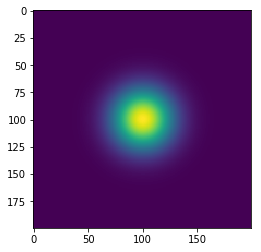

In [26]:
im_sub=im[ymin:ymax,xmin:xmax]
im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)


100
100


Text(0.5, 1.0, 'Residual')

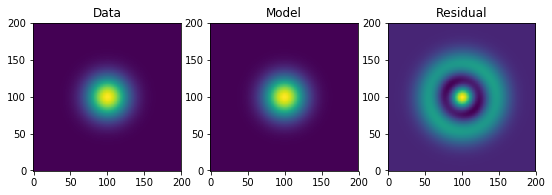

In [27]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [37]:
repr(p)

'<Gaussian2D(amplitude=7989.91279739, x_mean=100.30735841, y_mean=99.52711952, x_stddev=19.48341685, y_stddev=19.48409922, theta=0.)>'

In [ ]:
print(p)

In [42]:
# Make an radial plot
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])
#print(x_arr)
#print(tmp)
x_index_arr_2d=pix_index_1d_arr*ones_array_2d
x_arr_2d=x_index_arr_2d - p.x_mean.value
y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
# create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [39]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [40]:
r_arr_1d=np.reshape(r_arr_2d,(2*half_side)**2)
values = np.reshape(z,(2*half_side)**2)

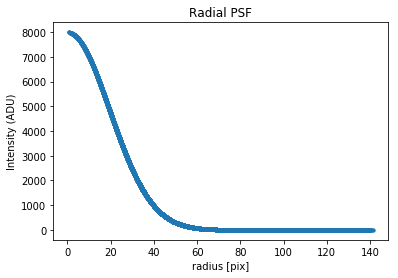

In [41]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(r_arr_1d, values,'.')
    plt.title('Radial PSF')
    plt.xlabel('radius [pix]')
    plt.show()
    plt.close()